In [2]:
import sys
import os

# Add the project directory to the Python path
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [3]:
!pip install pandas openpyxl
!pip install statsmodels
!pip install arch
!pip install tensorflow
!pip install boto3
!pip install requests
!pip install numpy
!pip install joblib matplotlib
!pip install prophet
!pip install tabulate

In [4]:
import pandas as pd
import numpy as np
import boto3
import joblib
import tarfile
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from scripts.preprocessing import load_data_csv, make_stationary, split_data, save_model_local, upload_model_s3, calculate_metrics
from prophet import Prophet
from scipy import stats
import seaborn as sns
from tabulate import tabulate

In [5]:
bucket = 'bk-price-prediction-data'
file_key = 'data/RICE/RICE_DATASET_1.csv'
separator = ','
df = load_data_csv(bucket, file_key, separator)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23416 entries, 0 to 23415
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    23416 non-null  object 
 1   PRICE   23416 non-null  float64
dtypes: float64(1), object(1)
memory usage: 366.0+ KB


In [6]:
# Get the median price per date
df = df.groupby('DATE')['PRICE'].mean().reset_index()
df = df.sort_values(by='DATE')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237 entries, 0 to 1236
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1237 non-null   object 
 1   PRICE   1237 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.5+ KB
None


In [7]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

In [8]:
# Remove outliers from the DataFrame
df_merge = df[(np.abs(stats.zscore(df['PRICE'])) < 3)]
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1236 entries, 2000-07-03 to 2024-07-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRICE   1236 non-null   float64
dtypes: float64(1)
memory usage: 19.3 KB


In [9]:
# Normalize data
scaler = MinMaxScaler()
df_merge['PRICE'] = scaler.fit_transform(df_merge[['PRICE']])

/tmp/ipykernel_4964/1781828679.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['PRICE'] = scaler.fit_transform(df_merge[['PRICE']])


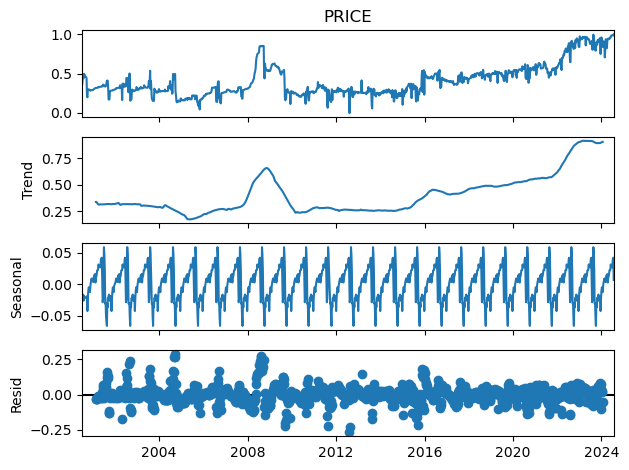

In [10]:
decomposition = seasonal_decompose(df_merge['PRICE'], model='additive', period=52)

# Plot the decomposition
decomposition.plot()
plt.show()

In [11]:
df_prophet = df_merge.reset_index().rename(columns={'DATE': 'ds', 'PRICE': 'y'})

In [12]:
train, test = split_data(df_prophet)

In [13]:
# Initialize and fit Prophet model
model = Prophet(
    changepoint_prior_scale=0.1,  # Controls the flexibility of the trend
    seasonality_prior_scale=10.0  # Controls the flexibility of the seasonality
)

# Add monthly seasonality explicitly
model.add_seasonality(name='weekly', period=30.5, fourier_order=5)

# Fit the model on your training data
model.fit(train)

18:59:46 - cmdstanpy - INFO - Chain [1] start processing
18:59:46 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Make predictions
forecast = model.predict(test)

In [15]:
# Evaluate the model
predictions = forecast['yhat'][-len(test):].values
true_values = test['y'].values

In [16]:
results=calculate_metrics(true_values,predictions)

In [17]:
print(tabulate(results, headers=["Metric", "Value"], tablefmt="grid"))

+----------+------------+
| Metric   |      Value |
+==========+============+
| MAE      |  0.124386  |
+----------+------------+
| MSE      |  0.0263112 |
+----------+------------+
| RMSE     |  0.162207  |
+----------+------------+
| MAPE     | 15.4182    |
+----------+------------+


In [18]:
name_model = 'model_rice'
save_model_local(model,name_model)

Created ../model/model_rice.tar.gz containing ../model/model_rice.joblib


In [19]:
# Upload the model to S3
upload_model_s3(name_model, bucket)

upload s3
